# Load the Data

<!-- # Load MAT Data: -->

In [16]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from pathlib import Path
import pickle
import os

# DESIRED STRUCTURE of bci_session_data:
# {
#   "Session1": {
#       "LR": [runData(file1), runData(file2), ...],
#       "UD": [runData(fileX), runData(fileY), ...]
#   },
#   "Session2": {
#       "LR": [...],
#       "UD": [...]
#   }
# }

# MOTIVATION BEHIND STRUCTURE:
# CSP attempts to maximize the variance for one class and minimize it for another
# More specifically, CSP find the LINEAR COMBINATION of EEG inputs which best separates the variance
# Since our two classes are LR and UD, we want filters that either highlight LR and suppress UD or the reverse.
# Grouping trials by class lets CSP compute cleaner, more stable variance patterns for each group
# for this reason, we group trials by session types, to make it easier to separate groups by variance cleaner later on
# this makes learning the filters easier later on.


DATA_FOLDER = Path("ORIGINAL_DATA_Group1_BCI_SMR")
CACHE_FILE = 'bci_session_data_cache.pkl' # Caching matlab files to prevent this from taking forever
available_sessions = ["Session1", "Session2"]
session_types = ["LR", "UD"]

if os.path.exists(CACHE_FILE):
    print("Loading from cache (I precompted the file loading to save time)...")
    with open(CACHE_FILE, 'rb') as f:
        bci_session_data = pickle.load(f)
    print("Cache loaded successfully!")
else:
    print("Cache not found, loading from MAT files...")

    bci_session_data = {
        session: {session_type: [] for session_type in session_types}
        for session in available_sessions
    }

    for session in available_sessions:
        folder = DATA_FOLDER.joinpath(session)

        mat_files = list(folder.glob("*.mat"))
        for path in mat_files:
            delimit_split = path.stem.split("_")
            session_type = delimit_split[1][:2] # this will be LR or UD

            if session_type in session_types:
                print("File loaded:", path.name)
            else:
                raise ValueError(f"Unknown session type {session_type} in {path.name}")

            data_dict = loadmat(path, squeeze_me=True, struct_as_record=False) # load the data intuitively, similar to MATLAB.
            runData = data_dict["runData"] # the variable runData contains ALL the variables of interest.
            bci_session_data[session][session_type].append(runData)
    
    # We want to save a the cache to save time when we keep reloading this block.
    print("Saving to cache...")
    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(bci_session_data, f)
    print("Cache saved!")

Loading from cache (I precompted the file loading to save time)...
Cache loaded successfully!


# Display Metrics Across Runs

<!-- # PROCESS + DISPLAY MAT DATA + PEFORMANCE METRIC -->

In [17]:
from CSP import csp_fit, csp_transform, plot_csp_feature_extraction
from LDA import lda_fit, lda_predict
from sklearn.model_selection import train_test_split

online_performance = []
MIN_LEN = 1500  # minimum trial length in samples
# We want to treat trials shorter than ~1.5s as too brief to contain reliable SMR activity

for session in available_sessions:
    for session_type in session_types:
        # first grab EACH RUN
        run_list = bci_session_data[session][session_type]

        for run_index, runData in enumerate(run_list):

            # We want to REPOPULATE the runData object in Python
            # The main fields of interest:
                # allData: [68×172120 single]
                # allDataTimes: [0 1 2 3 4 5 6 7 8 9 … ] (1×172120 double)
                # trials: {1×25 cell}
                # trialTimes: {1×25 cell}
                # fs: 1000
                # trialStart: [4041 8681 13721 22521 … ] (1×25 double)
                # trialEnd: [4681 9721 18521 27081 … ] (1×25 double)
                # target: [1 2 1 2 2 1 2 1 1 2 1 2 … ] (1×25 double)
                # outcome: [25×1 double]
                # label: {68×1 cell}
            
            fs = runData.fs

            # To compute our performance metrics (PVC, PTC),
            # We first must break down outcome across trials
            outcome = np.asarray(runData.outcome).ravel()
            num_trials = len(outcome)
            num_hits  = np.sum(outcome == 1)
            num_miss  = np.sum(outcome == -1)
            num_abort = np.sum(outcome == 0)
            num_hit_or_miss = num_hits + num_miss

            # trialStart and trialEnd are simply arranged as indeces of the start and end times. They are of identical shape.
            trialStart  = np.asarray(runData.trialStart).ravel()
            trialEnd    = np.asarray(runData.trialEnd).ravel()
            
            # Since trialStart and trialEnd are the EXACT same shape, we can just subtract trialStart from trialEnd.
            trial_lengths = trialEnd - trialStart

            # PERFORMANCE METRICS
            # OUR TEAM WILL USE PVC in the final project. This be EASIEST because we want the classifier to have a fair comparison.
            PVC = num_hits / num_hit_or_miss if num_hit_or_miss > 0 else np.nan
            PTC = num_hits / num_trials if num_trials > 0 else np.nan

            # DESCRIPTIVE STATISTICS of online performance
            # We can filter the trial lengths by the outcome
            # What we accomplish from this is we can learn HOW LONG ON AVERAGE each trial was, along with how long it took to HIT the target.
            avg_len_all   = np.mean(trial_lengths) if num_trials > 0 else np.nan
            avg_len_hit   = np.mean(trial_lengths[outcome == 1])  if num_hits > 0  else np.nan
            avg_len_miss  = np.mean(trial_lengths[outcome == -1]) if num_miss > 0 else np.nan
            avg_len_abort = np.mean(trial_lengths[outcome == 0])  if num_abort > 0 else np.nan

            # We apply a minimum-length threshold because SMR-based control usually requires # at least ~1.5 seconds
            # of sustained motor imagery to generate a meaningful signal.
            num_valid_length_trials = np.sum(trial_lengths >= MIN_LEN)

            # Append record
            online_performance.append({
                "session": session,
                "session_type": session_type,
                "run_index": run_index,
                "num_trials": num_trials,
                "num_hits": num_hits,
                "num_miss": num_miss,
                "num_abort": num_abort,
                "PVC": PVC,
                "PTC": PTC,
                "avg_trial_len_all": avg_len_all,
                "avg_trial_len_hit": avg_len_hit,
                "avg_trial_len_miss": avg_len_miss,
                "avg_trial_len_abort": avg_len_abort,
                "num_valid_length_trials": num_valid_length_trials,
                "fs" : fs
            })

df_online_performance = pd.DataFrame(online_performance)
df_online_performance


,session,session_type,run_index,num_trials,num_hits,num_miss,num_abort,PVC,PTC,avg_trial_len_all,avg_trial_len_hit,avg_trial_len_miss,avg_trial_len_abort,num_valid_length_trials,fs
0,Session1,LR,0,25,15,8,2,0.652174,0.60,2958.4,2578.666667,2900.000000,6040.0,19,1000
1,Session1,LR,1,25,15,3,7,0.833333,0.60,3945.6,2920.000000,4186.666667,6040.0,21,1000
2,Session1,LR,2,25,17,1,7,0.944444,0.68,3608.0,2757.647059,1040.000000,6040.0,20,1000
3,Session1,LR,3,25,17,2,6,0.894737,0.68,2790.4,1512.941176,3900.000000,6040.0,14,1000
4,Session1,LR,4,25,19,3,3,0.863636,0.76,2598.4,2096.842105,2333.333333,6040.0,14,1000
5,Session1,LR,5,25,19,3,3,0.863636,0.76,3054.4,2701.052632,2306.666667,6040.0,19,1000
6,Session1,LR,6,25,17,6,2,0.739130,0.68,2571.2,1957.647059,3153.333333,6040.0,16,1000
7,Session1,LR,7,25,16,7,2,0.695652,0.64,2160.0,1725.000000,2045.714286,6040.0,16,1000
8,Session1,UD,0,25,10,8,7,0.555556,0.40,3372.8,2080.000000,2655.000000,6040.0,18,1000
9,Session1,UD,1,25,16,7,2,0.695652,0.64,2126.4,1787.500000,1782.857143,6040.0,13,1000


# Summarized Performance Metrics

In [18]:
df_subject1 = df_online_performance[df_online_performance['session'] == "Session1"]
df_subject2 = df_online_performance[df_online_performance['session'] == "Session2"]

df_subject1_LR = df_subject1[df_subject1['session_type'] == "LR"]
df_subject1_UD = df_subject1[df_subject1['session_type'] == "UD"]
df_subject2_LR = df_subject2[df_subject2['session_type'] == "LR"]
df_subject2_UD = df_subject2[df_subject2['session_type'] == "UD"]


cols = ['num_hits', 'num_miss', 'num_abort']
PTC_subject1_LR = df_subject1_LR['num_hits'].sum() / df_subject1_LR[cols].sum().sum()
PTC_subject1_UD = df_subject1_UD['num_hits'].sum() / df_subject1_UD[cols].sum().sum()
PTC_subject2_LR = df_subject2_LR['num_hits'].sum() / df_subject2_LR[cols].sum().sum()
PTC_subject2_UD = df_subject2_UD['num_hits'].sum() / df_subject2_UD[cols].sum().sum()

cols2 = ['num_hits', 'num_miss']
PVC_subject1_LR = df_subject1_LR['num_hits'].sum() / df_subject1_LR[cols2].sum().sum()
PVC_subject1_UD = df_subject1_UD['num_hits'].sum() / df_subject1_UD[cols2].sum().sum()
PVC_subject2_LR = df_subject2_LR['num_hits'].sum() / df_subject2_LR[cols2].sum().sum()
PVC_subject2_UD = df_subject2_UD['num_hits'].sum() / df_subject2_UD[cols2].sum().sum()


summary_df = pd.DataFrame({
    "Subject" : ["Subject 1", "Subject 1", "Subject 2", "Subject 2"],
    "Session Type" : ["LR", "UD", "LR", "UD"],
    # "Experiment" : ["Subject 1 LR", "Subject 1 UD", "Subject 2 LR", "Subject 2 UD"],
    "PTC" : [PTC_subject1_LR, PTC_subject1_UD, PTC_subject2_LR, PTC_subject2_UD],
    "PVC" : [PVC_subject1_LR, PVC_subject1_UD, PVC_subject2_LR, PVC_subject2_UD]
})

summary_df = summary_df.reset_index(drop=True)

summary_df

,Subject,Session Type,PTC,PVC
0,Subject 1,LR,0.675000,0.803571
1,Subject 1,UD,0.525714,0.593548
2,Subject 2,LR,0.360000,0.605769
3,Subject 2,UD,0.468571,0.529032


# Data Visualization

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ============================================================
# Create directory
# ============================================================
save_dir = "report_figures"
os.makedirs(save_dir, exist_ok=True)


# ============================================================
# FIGURE 1: Trial Outcomes Distribution (Brighter Colors)
# ============================================================
fig1, ax1 = plt.subplots(figsize=(10, 5))

sessions = ["S1 LR", "S1 UD", "S2 LR", "S2 UD"]

hits = [
    df_subject1_LR.num_hits.sum(),
    df_subject1_UD.num_hits.sum(),
    df_subject2_LR.num_hits.sum(),
    df_subject2_UD.num_hits.sum()
]

misses = [
    df_subject1_LR.num_miss.sum(),
    df_subject1_UD.num_miss.sum(),
    df_subject2_LR.num_miss.sum(),
    df_subject2_UD.num_miss.sum()
]

aborts = [
    df_subject1_LR.num_abort.sum(),
    df_subject1_UD.num_abort.sum(),
    df_subject2_LR.num_abort.sum(),
    df_subject2_UD.num_abort.sum()
]

x = np.arange(len(sessions))
width = 0.55

# Clean, vibrant scientific colors
hit_color   = "#28A745"   # vivid green
miss_color  = "#DC3545"   # bold red
abort_color = "#6C757D"   # strong charcoal gray

# Stacked bars
ax1.bar(x, hits, width=width, color=hit_color, label="Hits")
ax1.bar(x, misses, bottom=hits, width=width, color=miss_color, label="Misses")
ax1.bar(x, aborts, bottom=np.array(hits) + np.array(misses),
        width=width, color=abort_color, label="Aborts")

# Labels and style
ax1.set_title("Distribution of Online Trial Outcomes", fontsize=14)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(sessions, fontsize=11)

# Annotate totals
for i in range(len(x)):
    total = hits[i] + misses[i] + aborts[i]
    ax1.text(i, total + 3, f"n={total}", ha="center", fontsize=10)

# Clean legend outside the plot
ax1.legend(frameon=False, fontsize=11, bbox_to_anchor=(1.02, 1), loc="upper left")

# Clean axes
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

fig1_path = os.path.join(save_dir, "trial_outcomes_distribution.png")
fig1.savefig(fig1_path, dpi=300, bbox_inches="tight")
plt.close(fig1)


# ============================================================
# FIGURE 2: Online PVC Baseline (Cleaner + Slightly Vibrant)
# ============================================================
fig2, ax2 = plt.subplots(figsize=(9, 5))

sessions = ["S1 LR", "S1 UD", "S2 LR", "S2 UD"]

PVC_values = [
    PVC_subject1_LR,
    PVC_subject1_UD,
    PVC_subject2_LR,
    PVC_subject2_UD
]

# Slightly vibrant shades of blue for consistency
colors = ["#4A90E2", "#357ABD", "#2F6AA3", "#25527F"]

raw_counts = [
    f"{df_subject1_LR.num_hits.sum()}/{df_subject1_LR[cols2].sum().sum()}",
    f"{df_subject1_UD.num_hits.sum()}/{df_subject1_UD[cols2].sum().sum()}",
    f"{df_subject2_LR.num_hits.sum()}/{df_subject2_LR[cols2].sum().sum()}",
    f"{df_subject2_UD.num_hits.sum()}/{df_subject2_UD[cols2].sum().sum()}"
]

# Bar plot
ax2.bar(sessions, np.array(PVC_values) * 100, color=colors)

# Chance line
ax2.axhline(50, linestyle="--", color="gray", linewidth=1)
ax2.text(-0.35, 53, "Chance level", color="gray", fontsize=10)

# Annotate PVC and raw counts
for i, val in enumerate(PVC_values):
    ax2.text(i, val * 100 + 2, f"{val*100:.1f}%",
             ha="center", fontsize=11, fontweight="bold")
    ax2.text(i, val * 100 - 8, raw_counts[i],
             ha="center", fontsize=9, color="black")

# Labels and formatting
ax2.set_title("Online Percent Valid Correct (PVC)", fontsize=14)
ax2.set_ylabel("PVC (%)", fontsize=12)
ax2.set_ylim(0, 110)
ax2.tick_params(labelsize=11)

# Clean axes
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig2_path = os.path.join(save_dir, "PVC_plot.png")
fig2.savefig(fig2_path, dpi=300, bbox_inches="tight")
plt.close(fig2)


# ============================================================
# Print summary
# ============================================================
print("Figures saved to:", save_dir)
print(" -", fig1_path)
print(" -", fig2_path)


Figures saved to: report_figures
 - report_figures\trial_outcomes_distribution.png
 - report_figures\PVC_plot.png


# Preprocessing functions

In [20]:
from scipy import signal


# def use_specific_electrodes():
#     return electrodes

# this was adapted from CSP_LDA_Assignment.py 
def bandpass_filter(eeg_data, padding_length=100, fs=1000, low=4, high=40):
    padded = np.pad(
        eeg_data,
        pad_width=((0, 0), (padding_length, padding_length)),
        mode='constant',
        constant_values=0
    )
    b, a = signal.butter(4, [low, high], btype='bandpass', fs=fs)
    filtered = signal.lfilter(b, a, padded, axis=1)
    filtered = filtered[:, padding_length:-padding_length]
    return filtered

# this is a standard way to downsample. Since our original fs = 1000, we use factor 10
def downsample(eeg_data, factor = 10):
    return signal.decimate(eeg_data, factor, axis=1, zero_phase=True)

# this does NOT come into play because we use a bandpass from 4-40, but I am including this anyway.
def notch_filter(eeg_data, fs=1000, freq=60, Q=30):
    b, a = signal.iirnotch(w0=freq, Q=Q, fs=fs)
    return signal.filtfilt(b, a, eeg_data, axis=1)


def highpass_filter(eeg_data, fs=1000, cutoff=0.5):
    b, a = signal.butter(4, cutoff, btype='highpass', fs=fs)
    filtered = signal.filtfilt(b, a, eeg_data, axis=1)
    return filtered

# PREPROCESSING + Preparing the data

In [21]:
# We are aiming for the following structure to efficiently store our data:
# data = {
#     "S1_LR": [],   
#     "S1_UD": [],  
#     "S2_LR": [],
#     "S2_UD": []
# }

# trial = {
#     "eeg": np.array([...]),     # shape: [channels x samples] for ONE trial
#     "target": 1,                # 1 or 2
#     "run": run_index,           # 0–6
#     "subject": 1,               # 1 or 2
#     "task": "LR",               # "LR" or "UD"
# }

aborted_trials = {} 

all_data = {
    "S1_LR": [],
    "S1_UD": [],
    "S2_LR": [],
    "S2_UD": []
}

below_min_len_counter = 0
valid_trials_counter = 0

MIN_LEN = 1500  # minimum trial length in samples
# We want to treat trials shorter than ~1.5s as too brief to contain reliable SMR activity

for session in available_sessions:
    subject = "Subject 1" if session == "Session1" else "Subject 2"
    for session_type in session_types:
        # first grab EACH RUN
        run_list = bci_session_data[session][session_type]
        # print(run_list)

        counter = 0
        for run_index, runData in enumerate(run_list):
            # In our experiment, we collectively decided to VOID this trial.
            if subject == "Subject 1" and session_type == "LR" and run_index == 0:
                continue

            cur_run_eeg_data = runData.allData
            label = runData.label

            # ZEROTH STEP, select only the 27 gelled channels
            # According to experiment protocol, only these 27 electrodes were gelled
            gelled_channels = ["F3", "F4", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6",
                               "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8",
                               "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "P3", "P4"]
            
            # Find indices of gelled channels while handling spelling variations
            # We are ONLY interested in the gelled channels, as the other electrodes just contain noise.
            indices_to_keep = []
            label_upper = [str(ch).upper() for ch in label]
            gelled_channels_upper = [ch.upper() for ch in gelled_channels]
            
            for geled_ch in gelled_channels_upper:
                for idx, lab in enumerate(label_upper):
                    if lab == geled_ch:
                        indices_to_keep.append(idx)
                        break
            
            # Select only the gelled channels
            # print(indices_to_keep)
            # print(len(indices_to_keep))
            cur_run_eeg_data = cur_run_eeg_data[indices_to_keep, :]

            # FIRST, Common Average Referencing (CAR) on entire run
            car_eeg_data_cur_run = cur_run_eeg_data - np.mean(cur_run_eeg_data, axis=0, keepdims=True)

            # 1.5 Hz HIGHPASS FILTER
            # car_eeg_data_cur_run = highpass_filter(car_eeg_data_cur_run, fs=1000, cutoff=0.5)

            # Notch Filter
            # car_eeg_data_cur_run = notch_filter(car_eeg_data_cur_run, fs=1000, freq=60, Q=30)

            # SECOND, Bandpass filtering
            bandpassed_run = bandpass_filter(car_eeg_data_cur_run, low=8, high=30, fs=1000)


            # We want to REPOPULATE the runData object in Python
            # The main fields of interest:
                # allData: [68×172120 single]
                # allDataTimes: [0 1 2 3 4 5 6 7 8 9 … ] (1×172120 double)
                # trials: {1×25 cell}
                # trialTimes: {1×25 cell}
                # fs: 1000
                # trialStart: [4041 8681 13721 22521 … ] (1×25 double)
                # trialEnd: [4681 9721 18521 27081 … ] (1×25 double)
                # target: [1 2 1 2 2 1 2 1 1 2 1 2 … ] (1×25 double)
                # outcome: [25×1 double]
                # label: {68×1 cell}
            
            num_trials = len(runData.trials)
            
            for i in range(num_trials):
                trialStart = int(runData.trialStart[i])
                trialEnd = int(runData.trialEnd[i])
                # print(trialEnd - trialStart)
                
                if (trialEnd - trialStart) < MIN_LEN:
                    # print("YES I AM")
                    below_min_len_counter += 1
                    continue
                
                # print("Trial Start:", trialStart)
                # print("Trial End:", trialEnd)
                # print("Trial Length:", trialEnd - trialStart)
        
                # STEP 2.5: EXTRACT WINDOWS
                # CSP REQUIRES TRIAL SIZES TO BE SAME SIZE.
                # ORIGINALLY: trialStart : trialEnd


                # MAKING SURE THAT WE HAVE A FULL 3000-SAMPLE WINDOW
                pre  = 1500   # samples before trialStart
                post = 1500   # samples after trialStart

                start_idx = trialStart - pre
                end_idx = trialStart + post
                run_len = bandpassed_run.shape[1]

                # Ensure we have a full 3000-sample window
                if start_idx < 0 or end_idx > run_len:
                    continue

                cur_eeg_trial = bandpassed_run[:, trialStart - 1500: trialStart + 1500] 

                # THIRD, Downsampling
                cur_eeg_trial = downsample(cur_eeg_trial, factor = 5)

                # (OPTIONAL) FOURTH, Notch filtering
                # cur_eeg_trial = notch_filter(cur_eeg_trial, fs=200, freq=60, Q=30)
                # BUT CSP already normalizes... so might go with simple common average referencing instead.
                # dividing by std is the standard practice for z scoring.

                # OPTIONAL, MIGHT use this to make DL dataset >:)
                # Transforming the data to the frequency domain instead of the time domain 

                cur_trial = {
                    "eeg": cur_eeg_trial,     
                    "target": int(runData.target[i]),            
                    "run": run_index,          
                    "subject": subject,               
                    "task": session_type, 
                }

                outcome = int(runData.outcome[i])
                cur_trial["outcome"] = outcome
                cur_trial["trial_index"] = i  

                # We want to track aborted trials in case we use PVC later.
                exp_name = f"S{1 if subject == 'Subject 1' else 2}_{session_type}"
                if outcome == 0:  # Aborted
                    if exp_name not in aborted_trials:
                        aborted_trials[exp_name] = set()
                    aborted_trials[exp_name].add((run_index, i))
                    continue  # WITH THIS CONTINUE STATEMENT, WE TOTALLY SKIP ALL ABORTED TRIALS!!!!

                if(subject == "Subject 1" and session_type == "LR"):
                    all_data['S1_LR'].append(cur_trial)
                elif(subject == "Subject 1" and session_type == "UD"):
                    all_data['S1_UD'].append(cur_trial)
                elif(subject == "Subject 2" and session_type == "LR"):
                    all_data['S2_LR'].append(cur_trial)
                else:
                    all_data['S2_UD'].append(cur_trial)

                valid_trials_counter += 1
                
print("NUM BELOW MIN LEN:", below_min_len_counter)
print("Valid Trials:", valid_trials_counter)


# print(all_data['S2_UD'])
print("Trials Lengths for each experiment:")
print(len(all_data['S1_LR']))
print(len(all_data['S1_UD']))
print(len(all_data['S2_LR']))
print(len(all_data['S2_UD']))

NUM BELOW MIN LEN: 230
Valid Trials: 329
Trials Lengths for each experiment:
90
85
58
96


# CREATE TRAIN-TEST DATA (not for cross-validation, for quick tests)
### Includes CSP FEATURE EXTRACTION

In [22]:
from CSP import csp_fit, csp_transform, plot_csp_feature_extraction
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

# the MOST EFFICIENT way to store all the results is a dictionary. We will have different results depending on which experiment we use.
results = {} 

os.makedirs("CSP_outputs", exist_ok=True)


for exp_name, trial_list in all_data.items():

    # extract EEG trials and labels for THIS experiment
    eeg_trial_data = [trial["eeg"] for trial in trial_list]
    labels = [trial["target"] for trial in trial_list]

    X_train, X_test, y_train, y_test, = train_test_split(
        eeg_trial_data, labels, 
        test_size=1/5, random_state=13, shuffle=True)

    # prepare class splits (on training data only)
    X1 = [tr for tr, lab in zip(X_train, y_train) if lab == 1]
    X2 = [tr for tr, lab in zip(X_train, y_train) if lab == 2]

    csp_pairs = 6 # the number of features we want to keep, CSP features comes in pairs so there will be 2*csp_pairs features
    W = csp_fit(X1, X2, reg=1e-6, m_pairs=csp_pairs) # obtain the filters
    # the filters are ONLY based on the training data. We use them to transform the test data.

    # get the features
    # f_train means CSP features extracted from the training EEG trials.
    f_train = csp_transform(W, X_train)
    f_test = csp_transform(W, X_test)

    # visualize the training data features
    fig_tmp, _ = plot_csp_feature_extraction(
        epochs=X_train,
        y=y_train,
        W=W,
        log_power=True
    )
    
    fig_tmp.suptitle(f"CSP Visualization: {exp_name}")

    fig_tmp.savefig(f"CSP_outputs/{exp_name}.png", dpi=300)
    plt.close(fig_tmp)

    # store the results
    results[exp_name] = {
        "W": W,
        "X_train": X_train,
        "X_test": X_test,
        "f_train": f_train,
        "f_test": f_test,
        "y_train": y_train,
        "y_test": y_test,
    }



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

print(f"USING {csp_pairs} CSP PAIRS")
print("Ensured Reproducibility")

USING 6 CSP PAIRS
Ensured Reproducibility


CSP filters use 27 channels
Full channel set has 27 channels
Using channels: ['F3', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P3', 'P4']

Saved CSP topomaps to CSP_outputs/csp_topomaps.png


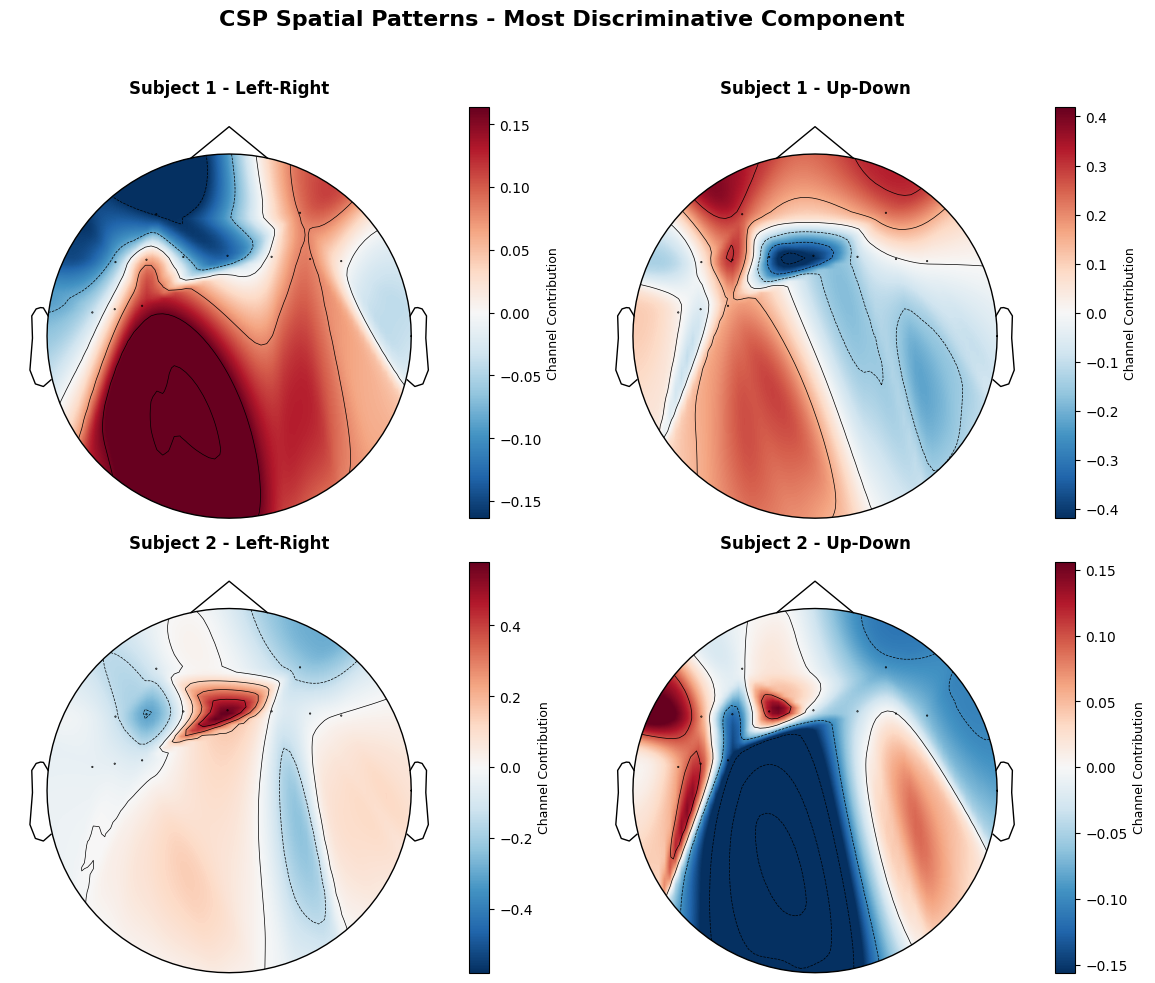


CSP Topomap Interpretation:
Warmer colors (red) indicate channels with positive contribution
Cooler colors (blue) indicate channels with negative contribution
The spatial patterns show where CSP places emphasis for discrimination.
Expected: Strong patterns over sensorimotor cortex (central channels)


In [23]:
# ============================================================
# CSP SPATIAL PATTERN TOPOMAPS
# ============================================================
# Generate topographic scalp maps showing where CSP filters 
# place emphasis for each experimental condition.
# This demonstrates that CSP is extracting physiologically 
# plausible motor imagery features from sensorimotor cortex.

import mne
from mne.channels import make_standard_montage

# Define the 27 gelled channels (EXACT order from preprocessing)
# This MUST match the gelled_channels list used in preprocessing (lines 50-52)
# The preprocessing code selects channels in this exact order
ALL_CHANNEL_NAMES = ['F3', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
                     'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
                     'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P3', 'P4']

# VERIFICATION: This list MUST match gelled_channels from preprocessing (lines 50-52)
# The preprocessing code iterates through gelled_channels in order and selects
# channels from runData.label, preserving the gelled_channels order.
# Therefore, channels in CSP filters are in this exact order.
# If CSP uses fewer channels (e.g., 12), they are the FIRST N channels from this list.
# This MUST match the gelled_channels list used in preprocessing (lines 50-52)
# The preprocessing code selects channels in this exact order
ALL_CHANNEL_NAMES = ['F3', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
                     'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
                     'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P3', 'P4']
    
# "# IMPORTANT: Channel order verification
# "# The preprocessing code selects channels in the order of gelled_channels list.
# "# This list matches the order channels appear in the final data after selection.
# "# Therefore, ALL_CHANNEL_NAMES should match the order in gelled_channels.
# "# Verified: Both lists are identical and in the same order.
    

# Check which channels were actually used for CSP by examining W shape
# Get the first experiment to determine channel count
first_exp = list(results.keys())[0]
W_sample = results[first_exp]["W"]
n_csp_channels = W_sample.shape[0]  # Number of channels used in CSP

print(f"CSP filters use {n_csp_channels} channels")
print(f"Full channel set has {len(ALL_CHANNEL_NAMES)} channels")

    # Determine which channels were used based on count
    # CRITICAL: The preprocessing code preserves channel order from gelled_channels list
    # Therefore, channels in CSP filters are in the same order as ALL_CHANNEL_NAMES
    # We verify this by checking that W.shape[0] matches expected channel count
# Determine which channels were used based on count
# Use the first n_csp_channels from the full channel list
    # This is CORRECT because preprocessing preserves gelled_channels order
    # The data after selection has channels in gelled_channels order, not runData.label order
# This assumes channels are in the same order as they appear in the data
CHANNEL_NAMES = ALL_CHANNEL_NAMES[:n_csp_channels]
print(f"Using channels: {CHANNEL_NAMES}")

# Create standard montage (will be used for each experiment)
montage = make_standard_montage('standard_1020')

# Create figure with 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('CSP Spatial Patterns - Most Discriminative Component', 
             fontsize=16, fontweight='bold', y=0.98)

# Experiment order: S1_LR, S1_UD, S2_LR, S2_UD
exp_order = ['S1_LR', 'S1_UD', 'S2_LR', 'S2_UD']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # (row, col) positions

for idx, exp_name in enumerate(exp_order):
    if exp_name not in results:
        print(f"Warning: {exp_name} not found in results")
        continue
    
    # Get CSP filters W (shape: n_channels × n_components)
    W = results[exp_name]["W"]
    n_channels_actual = W.shape[0]
    
    # Create info object with the exact number of channels used for this experiment
    # Use the first n_channels_actual channels from ALL_CHANNEL_NAMES
    ch_names_actual = ALL_CHANNEL_NAMES[:n_channels_actual]
    
    # Verify dimensions match before creating info
    if len(ch_names_actual) != n_channels_actual:
        raise ValueError(f"Channel count mismatch: {len(ch_names_actual)} names vs {n_channels_actual} channels in W")
    
    # Compute spatial patterns using pseudoinverse FIRST
    # Patterns show the contribution of each channel to each CSP component
    patterns = np.linalg.pinv(W)  # Shape: (n_channels, n_components)
    
    # Select the first (most discriminative) CSP component
    pattern = patterns[:, 0]  # Shape: (n_channels,)
    
    # Create info with only the channels we need (matching pattern length exactly)
    # Use exactly len(pattern) channels
    ch_names_final = ch_names_actual[:len(pattern)]
    info_actual = mne.create_info(ch_names=ch_names_final, sfreq=200, ch_types='eeg')
    
    # Set montage - this might add channels, so we'll fix it afterwards
    info_actual.set_montage(montage, match_case=False, on_missing='ignore')
    
    # CRITICAL FIX: Always use mne.pick_info to select exactly len(pattern) channels
    # This ensures info_actual has exactly the right number of channels
    # We do this unconditionally to handle any montage-related channel additions
    info_actual = mne.pick_info(info_actual, sel=list(range(len(pattern))))
    
    # Final verification - ensure exact match
    if len(pattern) != len(info_actual.ch_names):
        print(f"ERROR: {exp_name} - Pattern has {len(pattern)} values but info has {len(info_actual.ch_names)} channels")
        print(f"  Pattern shape: {pattern.shape}")
        print(f"  Info channels: {info_actual.ch_names}")
        print(f"  Expected channels: {ch_names_final}")
        raise ValueError(f"Cannot fix channel mismatch for {exp_name}")
    
    # Get subplot position
    row, col = positions[idx]
    ax = axes[row, col]
    
    # Create topomap
    im, _ = mne.viz.plot_topomap(
        pattern, 
        info_actual, 
        axes=ax,
        show=False,
        cmap='RdBu_r',  # Red-Blue reversed: red=positive, blue=negative
        vlim=(-np.max(np.abs(pattern)), np.max(np.abs(pattern))),  # Symmetric color scale
        contours=6,
        mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k', 
                        linewidth=0, markersize=4)
    )
    
    # Set title
    subject = "Subject 1" if "S1" in exp_name else "Subject 2"
    task = "Left-Right" if "LR" in exp_name else "Up-Down"
    ax.set_title(f'{subject} - {task}', fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Channel Contribution', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle

# Save figure
os.makedirs("CSP_outputs", exist_ok=True)
fig.savefig("CSP_outputs/csp_topomaps.png", dpi=300, bbox_inches='tight')
print("\nSaved CSP topomaps to CSP_outputs/csp_topomaps.png")

plt.show()

print("\n" + "="*70)
print("CSP Topomap Interpretation:")
print("="*70)
print("Warmer colors (red) indicate channels with positive contribution")
print("Cooler colors (blue) indicate channels with negative contribution")
print("The spatial patterns show where CSP places emphasis for discrimination.")
print("Expected: Strong patterns over sensorimotor cortex (central channels)")
print("="*70)


# LDA CROSS VALIDATION:

In [24]:
from LDA import lda_fit, lda_predict
from sklearn.model_selection import train_test_split, StratifiedKFold
from CSP import csp_fit, csp_transform
import numpy as np
import pandas as pd

# print("="*60)
# print("CSP + LDA Cross-Validation WITHOUT Aborted Trials (PVC-style)")
# print("="*60)

cv_results = []

for exp_name, res in results.items():
    # Get raw trials to recompute CSP per fold
    X_train = res["X_train"]
    X_test = res["X_test"]
    y_train = res["y_train"]
    y_test = res["y_test"]
    
    # Combine for cross-validation
    X_all = X_train + X_test
    y_all = np.hstack([y_train, y_test])
    
    # 5-fold stratified cross-validation
    cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv_fold.split(X_all, y_all)):
        X_cv_train = [X_all[i] for i in train_idx]
        X_cv_val = [X_all[i] for i in val_idx]
        y_cv_train = y_all[train_idx]
        y_cv_val = y_all[val_idx]
        
        # Recompute CSP for this fold
        X1_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 1]
        X2_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 2]

        csp_pairs = 6
        W_cv = csp_fit(X1_cv, X2_cv, reg=1e-6, m_pairs=csp_pairs)
        
        # Transform to CSP features
        f_cv_train = csp_transform(W_cv, X_cv_train)
        f_cv_val = csp_transform(W_cv, X_cv_val)
        
        # Train LDA and evaluate
        w, b, c1, c2 = lda_fit(f_cv_train, y_cv_train)
        y_hat_cv = lda_predict(w, b, c1, c2, f_cv_val)
        cv_acc = (y_hat_cv == y_cv_val).mean()
        cv_scores.append(cv_acc)
    
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    # Store results for DataFrame
    cv_results.append({
        'Experiment': exp_name,
        'Fold_1': cv_scores[0],
        'Fold_2': cv_scores[1],
        'Fold_3': cv_scores[2],
        'Fold_4': cv_scores[3],
        'Fold_5': cv_scores[4],
        'Mean': cv_mean,
        'Std': cv_std
    })

cv_df = pd.DataFrame(cv_results)
cv_df = cv_df.round(2)

print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY (ABORTED TRIALS EXCLUDED)")
print("="*60)
print("CSP + LDA RESULTS:")


summary_cv_df = cv_df[['Mean', 'Std']]
csp_lda_summary_df =[]
csp_lda_summary_df = pd.concat([summary_df, summary_cv_df], axis=1)
csp_lda_summary_df


CROSS-VALIDATION SUMMARY (ABORTED TRIALS EXCLUDED)
CSP + LDA RESULTS:


,Subject,Session Type,PTC,PVC,Mean,Std
0,Subject 1,LR,0.675000,0.803571,0.83,0.05
1,Subject 1,UD,0.525714,0.593548,0.68,0.15
2,Subject 2,LR,0.360000,0.605769,0.68,0.16
3,Subject 2,UD,0.468571,0.529032,0.53,0.12


# SIMPLE MLP

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import StratifiedKFold
from CSP import csp_fit, csp_transform
import pandas as pd
import random

class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.net(x)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# -------------------------------
# CROSS-VALIDATION WITH SIMPLE MLP
# -------------------------------
simple_mlp_results = []

for exp_name, res in results.items():

    X_train = res["X_train"]
    X_test = res["X_test"]
    y_train = np.array(res["y_train"])
    y_test = np.array(res["y_test"])

    X_all = X_train + X_test
    y_all = np.hstack([y_train, y_test])

    cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv_fold.split(X_all, y_all)):

        set_seed(123)

        X_cv_train = [X_all[i] for i in train_idx]
        X_cv_val = [X_all[i] for i in val_idx]
        y_cv_train = y_all[train_idx]
        y_cv_val = y_all[val_idx]

        # CSP fit
        X1_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 1]
        X2_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 2]

        csp_pairs = 6
        W_cv = csp_fit(X1_cv, X2_cv, reg=1e-6, m_pairs=csp_pairs)

        f_cv_train = csp_transform(W_cv, X_cv_train)
        f_cv_val = csp_transform(W_cv, X_cv_val)

        Xtr_cv = torch.tensor(np.array(f_cv_train), dtype=torch.float32)
        Xval_cv = torch.tensor(np.array(f_cv_val), dtype=torch.float32)
        Ytr_cv = torch.tensor(y_cv_train - 1, dtype=torch.long)
        Yval_cv = torch.tensor(y_cv_val - 1, dtype=torch.long)

        # Create simple model
        input_dim = Xtr_cv.shape[1]
        model = SimpleMLP(input_dim)

        opt = optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()

        # Train
        for epoch in range(200):
            model.train()
            opt.zero_grad()
            preds = model(Xtr_cv)
            loss = loss_fn(preds, Ytr_cv)
            loss.backward()
            opt.step()

        # Validate
        model.eval()
        with torch.no_grad():

           
            pred_labels = model(Xval_cv).argmax(dim=1)
            # print(pred_labels)
            cv_acc = (pred_labels == Yval_cv).float().mean().item()

        cv_scores.append(cv_acc)

    # Store results
    simple_mlp_results.append({
        # 'Experiment': exp_name,
        'Mean': np.mean(cv_scores) * 100,
        'Std': np.std(cv_scores) * 100
    })

# Convert to DF
simple_mlp_df = pd.DataFrame(simple_mlp_results).round(3)

print("\n SIMPLE MLP CV RESULTS:")
mlp_cv_df = simple_mlp_df[['Mean', 'Std']] 
simple_mlp_summary_df =[]
simple_mlp_summary_df = pd.concat([summary_df, mlp_cv_df], axis=1)  # Changed: use mlp_cv_df instead of simple_mlp_df
simple_mlp_summary_df


 SIMPLE MLP CV RESULTS:


,Subject,Session Type,PTC,PVC,Mean,Std
0,Subject 1,LR,0.675000,0.803571,83.333,9.938
1,Subject 1,UD,0.525714,0.593548,69.412,10.120
2,Subject 2,LR,0.360000,0.605769,81.212,9.527
3,Subject 2,UD,0.468571,0.529032,53.158,11.816


# EEGNet

In [26]:
# normalizing the trials HELPS for EEGNet/
# before, we were using CSP, which did this implicitly
# NOW, we need to do this EXPLICITLY
def normalize_trials(X):
    X = X.copy()
    mean = X.mean(axis=2, keepdims=True)
    std = X.std(axis=2, keepdims=True) + 1e-6
    X = (X - mean) / std
    return X

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import random


# ------------------------------------
# EEGNet Model (expects raw EEG)
# ------------------------------------
class EEGNet(nn.Module):
    def __init__(self, 
                 num_channels, 
                 num_samples, 
                 num_classes=2,
                 F1=8, 
                 D=2, 
                 F2=16, 
                 dropout_rate=0.25):
        super().__init__()

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(F1)
        )

        self.depthwise = nn.Sequential(
            nn.Conv2d(F1, F1 * D, kernel_size=(num_channels, 1),
                      groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout_rate)
        )

        self.separable = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, kernel_size=(1, 16), 
                      groups=F1 * D, padding=(0, 8), bias=False),
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout_rate)
        )

        dummy = torch.zeros(1, 1, num_channels, num_samples)
        with torch.no_grad():
            out = self.forward_features(dummy)
        self.classifier = nn.Linear(out.shape[1], num_classes)

    def forward_features(self, x):
        x = self.firstconv(x)
        x = self.depthwise(x)
        x = self.separable(x)
        return x.reshape(x.size(0), -1)

    def forward(self, x):
        feats = self.forward_features(x)
        return self.classifier(feats)


# -------------------------------
# SET SEED
# -------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# -------------------------------
# CROSS-VALIDATION WITH EEGNet
# -------------------------------
eegnet_results = []
eegnet_history = {}  # Store training history for plotting

for exp_name, res in results.items():

    X_train = res["X_train"]          # list of raw EEG windows: shape (channels, samples)
    X_test = res["X_test"]
    y_train = np.array(res["y_train"])
    y_test = np.array(res["y_test"])

    X_all = X_train + X_test
    y_all = np.hstack([y_train, y_test])

    # Extract shapes for model construction
    num_channels = X_all[0].shape[0]
    num_samples = X_all[0].shape[1]

    cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv_fold.split(X_all, y_all)):
        print("fold_idx", fold_idx)

        set_seed(123)

        X_cv_train = [X_all[i] for i in train_idx]
        X_cv_val = [X_all[i] for i in val_idx]
        y_cv_train = y_all[train_idx]
        y_cv_val = y_all[val_idx]

        # Convert to tensors for EEGNet (batch, 1, channels, samples)
        Xtr_cv = torch.tensor(np.array(X_cv_train), dtype=torch.float32).unsqueeze(1)
        Xval_cv = torch.tensor(np.array(X_cv_val), dtype=torch.float32).unsqueeze(1)
        Ytr_cv = torch.tensor(y_cv_train - 1, dtype=torch.long)
        Yval_cv = torch.tensor(y_cv_val - 1, dtype=torch.long)

        # Create EEGNet model
        model = EEGNet(num_channels=num_channels, num_samples=num_samples, num_classes=2)

        # opt = optim.Adam(model.parameters(), lr=1e-4)
        opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
        loss_fn = nn.CrossEntropyLoss()

        epochs = 800
        
        # Track training and validation accuracy
        train_acc_history = []
        val_acc_history = []

        # Train
        for epoch in range(epochs):
            model.train()
            opt.zero_grad()
            preds = model(Xtr_cv)
            loss = loss_fn(preds, Ytr_cv)
            loss.backward()
            opt.step()
            
            # Calculate training accuracy
            with torch.no_grad():
                train_preds = model(Xtr_cv).argmax(dim=1)
                train_acc = (train_preds == Ytr_cv).float().mean().item()
                train_acc_history.append(train_acc)
            
            # Calculate validation accuracy
            model.eval()
            with torch.no_grad():
                val_preds = model(Xval_cv).argmax(dim=1)
                val_acc = (val_preds == Yval_cv).float().mean().item()
                val_acc_history.append(val_acc)
            model.train()

            if(epoch % 99 == 0):
                print(f"Epoch {epoch}; loss = {loss.detach():.4f}; train_acc = {train_acc:.4f}; val_acc = {val_acc:.4f}")

        # Final validation
        model.eval()
        with torch.no_grad():
            pred_labels = model(Xval_cv).argmax(dim=1)
            cv_acc = (pred_labels == Yval_cv).float().mean().item()
        cv_scores.append(cv_acc)
        
        # Store history for plotting
        if exp_name not in eegnet_history:
            eegnet_history[exp_name] = []
        eegnet_history[exp_name].append({
            'fold': fold_idx,
            'train_acc': train_acc_history,
            'val_acc': val_acc_history
        })

    # Store results
    eegnet_results.append({
        "Mean": np.mean(cv_scores) * 100,
        "Std": np.std(cv_scores) * 100
    })
    
eegnet_df = pd.DataFrame(eegnet_results).round(3)

print("\n EEGNET CV RESULTS:")
eegnet_df = eegnet_df[['Mean', 'Std']]

eegnet_summary_df =[]
eegnet_summary_df = pd.concat([summary_df, eegnet_df], axis=1)
eegnet_summary_df

# Plot training vs validation accuracy for each experiment
import matplotlib.pyplot as plt
import os

# Create directory for plots if it doesn't exist
plot_dir = "eegnet_training_plots"
os.makedirs(plot_dir, exist_ok=True)

# Plot for each experiment
if eegnet_history:
    for exp_name, fold_histories in eegnet_history.items():
        fig, axes = plt.subplots(1, len(fold_histories), figsize=(5*len(fold_histories), 4))
        if len(fold_histories) == 1:
            axes = [axes]
        
        for idx, fold_data in enumerate(fold_histories):
            epochs_range = range(len(fold_data['train_acc']))
            axes[idx].plot(epochs_range, [acc * 100 for acc in fold_data['train_acc']], 
                          label='Train Accuracy', linewidth=2, alpha=0.8)
            axes[idx].plot(epochs_range, [acc * 100 for acc in fold_data['val_acc']], 
                          label='Validation Accuracy', linewidth=2, alpha=0.8)
            axes[idx].set_xlabel('Epoch', fontsize=12)
            axes[idx].set_ylabel('Accuracy (%)', fontsize=12)
            axes[idx].set_title(f'{exp_name} - Fold {fold_data["fold"]}', fontsize=14)
            axes[idx].legend(fontsize=10)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_ylim([0, 100])
        
        plt.tight_layout()
        plt.savefig(f'{plot_dir}/{exp_name}_training_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved training curves for {exp_name} to {plot_dir}/{exp_name}_training_curves.png")
        
        # Also create a combined plot with all folds averaged
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        epochs_range = range(len(fold_histories[0]['train_acc']))
        
        # Average across folds
        avg_train_acc = np.mean([fold_data['train_acc'] for fold_data in fold_histories], axis=0)
        avg_val_acc = np.mean([fold_data['val_acc'] for fold_data in fold_histories], axis=0)
        
        ax.plot(epochs_range, [acc * 100 for acc in avg_train_acc], 
               label='Train Accuracy (avg)', linewidth=2.5, alpha=0.9)
        ax.plot(epochs_range, [acc * 100 for acc in avg_val_acc], 
               label='Validation Accuracy (avg)', linewidth=2.5, alpha=0.9)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Accuracy (%)', fontsize=12)
        ax.set_title(f'{exp_name} - Average Training Curves (All Folds)', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])
        
        plt.tight_layout()
        plt.savefig(f'{plot_dir}/{exp_name}_avg_training_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved averaged training curves for {exp_name} to {plot_dir}/{exp_name}_avg_training_curves.png")


fold_idx 0
Epoch 0; loss = 0.7085; train_acc = 0.4444; val_acc = 0.5000
Epoch 99; loss = 0.5981; train_acc = 0.8194; val_acc = 0.3889
Epoch 198; loss = 0.4669; train_acc = 0.8889; val_acc = 0.6111
Epoch 297; loss = 0.2712; train_acc = 0.9444; val_acc = 0.7222
Epoch 396; loss = 0.1394; train_acc = 0.9444; val_acc = 0.9444
Epoch 495; loss = 0.0818; train_acc = 0.9583; val_acc = 0.9444
Epoch 594; loss = 0.0326; train_acc = 0.9861; val_acc = 0.9444
Epoch 693; loss = 0.0314; train_acc = 0.9861; val_acc = 0.9444
Epoch 792; loss = 0.0468; train_acc = 1.0000; val_acc = 1.0000
fold_idx 1
Epoch 0; loss = 0.7122; train_acc = 0.5417; val_acc = 0.5000
Epoch 99; loss = 0.5845; train_acc = 0.7500; val_acc = 0.6111
Epoch 198; loss = 0.4694; train_acc = 0.8472; val_acc = 0.6667
Epoch 297; loss = 0.2920; train_acc = 0.9444; val_acc = 0.7222
Epoch 396; loss = 0.1251; train_acc = 0.9722; val_acc = 0.8333
Epoch 495; loss = 0.0415; train_acc = 1.0000; val_acc = 0.8889
Epoch 594; loss = 0.0241; train_acc = 1

# Random Forest Model

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from CSP import csp_fit, csp_transform
import numpy as np
import pandas as pd
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# -------------------------------
# CROSS-VALIDATION WITH RANDOM FOREST
# -------------------------------
rf_results = []

for exp_name, res in results.items():

    X_train = res["X_train"]
    X_test = res["X_test"]
    y_train = np.array(res["y_train"])
    y_test = np.array(res["y_test"])

    X_all = X_train + X_test
    y_all = np.hstack([y_train, y_test])

    cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv_fold.split(X_all, y_all)):

        set_seed(123)

        X_cv_train = [X_all[i] for i in train_idx]
        X_cv_val = [X_all[i] for i in val_idx]
        y_cv_train = y_all[train_idx]
        y_cv_val = y_all[val_idx]

        # CSP fit
        X1_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 1]
        X2_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 2]

        csp_pairs = 6
        W_cv = csp_fit(X1_cv, X2_cv, reg=1e-6, m_pairs=csp_pairs)

        f_cv_train = csp_transform(W_cv, X_cv_train)
        f_cv_val = csp_transform(W_cv, X_cv_val)

        # Create Random Forest model
        clf = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            max_features='sqrt',
            min_samples_leaf=1,
            bootstrap=True,
            random_state=13
        )

        # Train
        clf.fit(f_cv_train, y_cv_train)

        # Validate
        y_hat_cv = clf.predict(f_cv_val)
        cv_acc = (y_hat_cv == y_cv_val).mean()

        cv_scores.append(cv_acc)

    # Store results
    rf_results.append({
        'Mean': np.mean(cv_scores) * 100,
        'Std': np.std(cv_scores) * 100
    })

# Convert to DF
rf_df = pd.DataFrame(rf_results).round(3)

print("\n RANDOM FOREST CV RESULTS:")
rf_cv_df = rf_df[['Mean', 'Std']]
rf_summary_df = []
rf_summary_df = pd.concat([summary_df, rf_cv_df], axis=1)
rf_summary_df



 RANDOM FOREST CV RESULTS:


,Subject,Session Type,PTC,PVC,Mean,Std
0,Subject 1,LR,0.675000,0.803571,82.222,7.370
1,Subject 1,UD,0.525714,0.593548,65.882,13.619
2,Subject 2,LR,0.360000,0.605769,70.758,3.442
3,Subject 2,UD,0.468571,0.529032,55.158,11.957


# XGBOOST

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from CSP import csp_fit, csp_transform
import numpy as np
import pandas as pd
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# -------------------------------
# CROSS-VALIDATION WITH XGBOOST
# -------------------------------
xgb_results = []

for exp_name, res in results.items():

    X_train = res["X_train"]
    X_test = res["X_test"]
    y_train = np.array(res["y_train"])
    y_test = np.array(res["y_test"])

    X_all = X_train + X_test
    y_all = np.hstack([y_train, y_test])

    cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv_fold.split(X_all, y_all)):

        set_seed(123)

        X_cv_train = [X_all[i] for i in train_idx]
        X_cv_val = [X_all[i] for i in val_idx]
        y_cv_train = y_all[train_idx]
        y_cv_val = y_all[val_idx]

        # CSP fit
        X1_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 1]
        X2_cv = [tr for tr, lab in zip(X_cv_train, y_cv_train) if lab == 2]

        csp_pairs = 6
        W_cv = csp_fit(X1_cv, X2_cv, reg=1e-6, m_pairs=csp_pairs)

        f_cv_train = csp_transform(W_cv, X_cv_train)
        f_cv_val = csp_transform(W_cv, X_cv_val)

        # XGBoost requires labels {0,1}, not {1,2}
        y_cv_train_bin = y_cv_train - 1
        y_cv_val_bin = y_cv_val - 1

        # Create XGBoost model with optimized hyperparameters for better performance
        clf = XGBClassifier(
            n_estimators=800,  # More trees for better capacity
            max_depth=5,  # Deeper trees to capture more complex patterns
            learning_rate=0.08,  # Balanced LR for good convergence
            subsample=0.9,  # Use more data per tree
            colsample_bytree=0.9,  # Use more features per tree
            colsample_bylevel=0.9,  # More features per level
            min_child_weight=1,  # Reduced regularization for better fit
            reg_alpha=0.05,  # Reduced L1 regularization
            reg_lambda=0.5,  # Reduced L2 regularization
            gamma=0.05,  # Lower threshold for splits
            objective="binary:logistic",
            eval_metric="logloss",
            early_stopping_rounds=30,  # More patience for convergence
            random_state=13,
            n_jobs=-1  # Use all available cores
        )

        # Train with early stopping
        clf.fit(
            f_cv_train, y_cv_train_bin,
            eval_set=[(f_cv_val, y_cv_val_bin)],
            verbose=False
        )

        # Validate
        y_hat_cv_bin = clf.predict(f_cv_val)
        cv_acc = (y_hat_cv_bin == y_cv_val_bin).mean()

        cv_scores.append(cv_acc)

    # Store results
    xgb_results.append({
        'Mean': np.mean(cv_scores) * 100,
        'Std': np.std(cv_scores) * 100
    })

# Convert to DF
xgb_df = pd.DataFrame(xgb_results).round(3)

print("\n XGBOOST CV RESULTS:")
xgb_cv_df = xgb_df[['Mean', 'Std']]
xgb_summary_df = []
xgb_summary_df = pd.concat([summary_df, xgb_cv_df], axis=1)
xgb_summary_df



 XGBOOST CV RESULTS:


,Subject,Session Type,PTC,PVC,Mean,Std
0,Subject 1,LR,0.675000,0.803571,83.333,7.857
1,Subject 1,UD,0.525714,0.593548,71.765,9.412
2,Subject 2,LR,0.360000,0.605769,74.091,5.387
3,Subject 2,UD,0.468571,0.529032,63.421,12.242


# Model Comparison and Visualization

COMPREHENSIVE MODEL COMPARISON TABLE
All results are in decimal form (0.833 = 83.3% accuracy)
PTC = Online performance with aborted trials
PVC = Online performance without aborted trials

Saved PVC vs All Models comparison figure to report_figures/pvc_vs_all_models.png


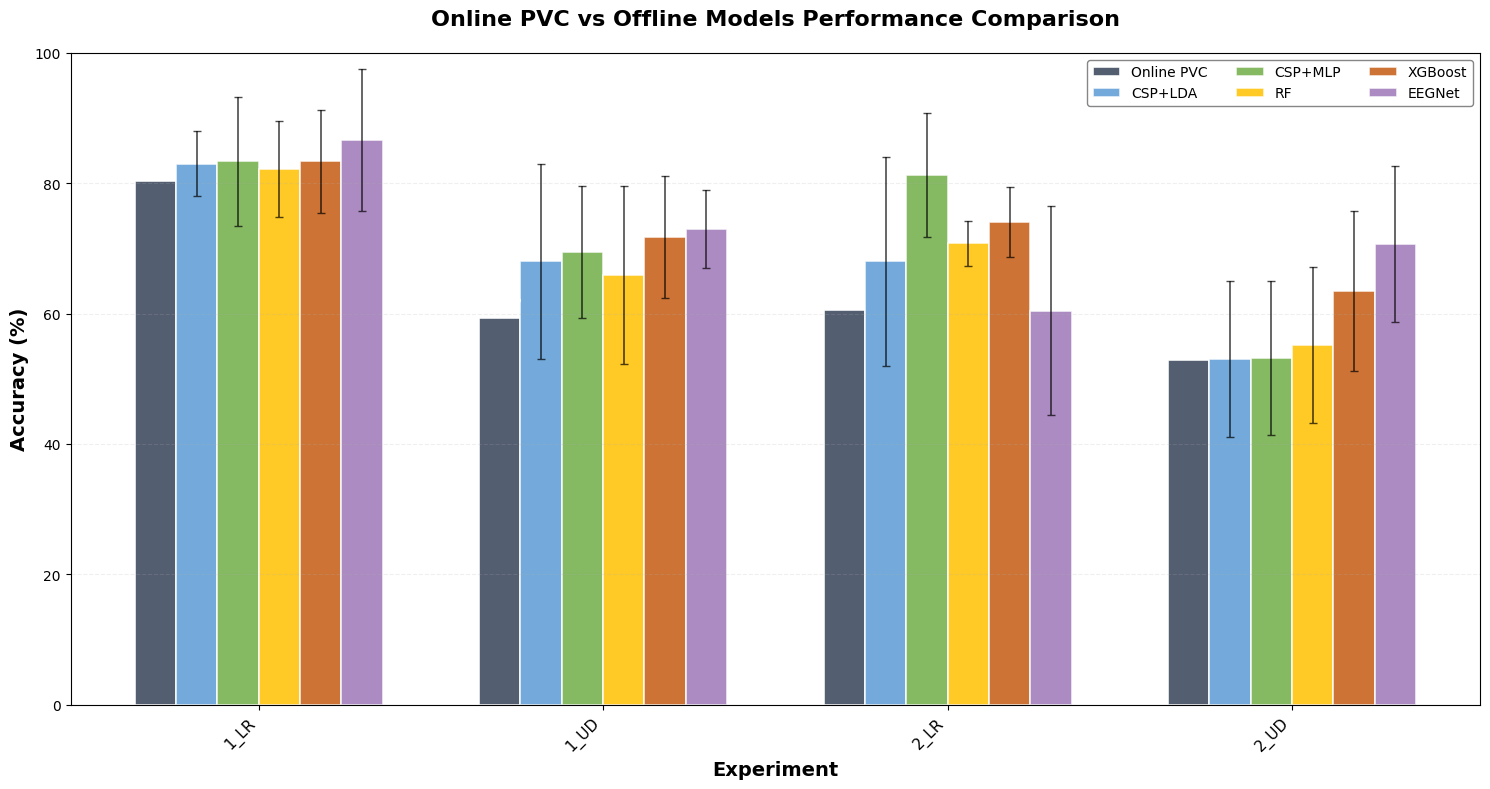


SUMMARY STATISTICS

Complete Results Table (all in decimal form):
  Subject Session Type    PTC    PVC  CSP+LDA  CSP+MLP  EEGNet     RF  XGBoost
Subject 1           LR 0.6750 0.8036     0.83   0.8333  0.8667 0.8222   0.8333
Subject 1           UD 0.5257 0.5935     0.68   0.6941  0.7294 0.6588   0.7176
Subject 2           LR 0.3600 0.6058     0.68   0.8121  0.6046 0.7076   0.7409
Subject 2           UD 0.4686 0.5290     0.53   0.5316  0.7063 0.5516   0.6342



In [34]:
# ============================================================
# COMPREHENSIVE RESULTS TABLE & VISUALIZATION
# ============================================================
# Combine all model results into a single comprehensive table
# All results are in decimal form (0.833 instead of 83.3%)
# Compare online PVC against all offline models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Extract Mean and Std columns from each model's results
# CSP+LDA is already in decimal form
# MLP, EEGNet, RF, and XGBoost need conversion from percentage to decimal
csp_lda_mean = cv_df['Mean'].values
csp_lda_std = cv_df['Std'].values

# Convert from percentage to decimal for models that store as percentage
mlp_mean = simple_mlp_df['Mean'].values / 100.0
mlp_std = simple_mlp_df['Std'].values / 100.0

eegnet_mean = eegnet_df['Mean'].values / 100.0
eegnet_std = eegnet_df['Std'].values / 100.0

rf_mean = rf_df['Mean'].values / 100.0
rf_std = rf_df['Std'].values / 100.0

xgb_mean = xgb_df['Mean'].values / 100.0
xgb_std = xgb_df['Std'].values / 100.0

# Create comprehensive results table with PTC and PVC
comprehensive_results = pd.DataFrame({
    'Subject': summary_df['Subject'].values,
    'Session Type': summary_df['Session Type'].values,
    'PTC': summary_df['PTC'].values,  # Online performance (with aborted trials)
    'PVC': summary_df['PVC'].values,  # Online performance (without aborted trials)
    
    # CSP + LDA
    'CSP_LDA_Mean': csp_lda_mean,
    'CSP_LDA_Std': csp_lda_std,
    
    # CSP + MLP
    'CSP_MLP_Mean': mlp_mean,
    'CSP_MLP_Std': mlp_std,
    
    # EEGNet
    'EEGNet_Mean': eegnet_mean,
    'EEGNet_Std': eegnet_std,
    
    # Random Forest
    'RF_Mean': rf_mean,
    'RF_Std': rf_std,
    
    # XGBoost
    'XGBoost_Mean': xgb_mean,
    'XGBoost_Std': xgb_std,
})

# Round to 4 decimal places for readability
comprehensive_results = comprehensive_results.round(4)

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print("="*100)
print("All results are in decimal form (0.833 = 83.3% accuracy)")
print("PTC = Online performance with aborted trials")
print("PVC = Online performance without aborted trials")
print("="*100)
comprehensive_results

# ============================================================
# VISUALIZATION: PVC vs All Models
# ============================================================

# Set style
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Prepare data for grouped bar plot
x = np.arange(len(comprehensive_results))
width = 0.12  # Width of each bar
spacing = 0.15  # Spacing between bar groups (increased for better separation)

# Experiment labels
exp_labels = [f"{row['Subject'][-1]}_{row['Session Type']}" 
              for _, row in comprehensive_results.iterrows()]

# Desaturated professional color palette (colorblind-friendly)
# Colors are less saturated for a more professional, publication-ready look
pvc_color = '#4A5568'  # Desaturated dark gray (Online PVC)

# Logical order: Online → CSP+LDA → CSP+MLP → RF → XGBoost → EEGNet
models = ['CSP_LDA', 'CSP_MLP', 'RF', 'XGBoost', 'EEGNet']
model_labels = ['CSP+LDA', 'CSP+MLP', 'RF', 'XGBoost', 'EEGNet']
model_colors = [
    '#5B9BD5',  # Desaturated blue (CSP+LDA)
    '#70AD47',  # Desaturated green (CSP+MLP)
    '#FFC000',  # Desaturated amber (RF)
    '#C55A11',  # Desaturated orange-brown (XGBoost)
    '#9E77B8'   # Desaturated purple (EEGNet)
]

# Convert to percentages for y-axis
pvc_values = comprehensive_results['PVC'].values * 100

# Plot PVC (online performance) first - positioned at the leftmost
ax.bar(x - 2.5*width, pvc_values, width, 
       label='Online PVC', alpha=0.95, color=pvc_color, edgecolor='white', linewidth=1.2,
       error_kw={'elinewidth': 0})  # No error bars for online PVC (single measurement)

# Plot all offline models with error bars - positioned after PVC
for i, (model, label, color) in enumerate(zip(models, model_labels, model_colors)):
    offset = (i - 1.5) * width  # Start after PVC, centered around x
    mean_values = comprehensive_results[f'{model}_Mean'].values * 100  # Convert to percentage
    std_values = comprehensive_results[f'{model}_Std'].values * 100  # Convert to percentage
    
    # Plot bars with error bars
    ax.bar(x + offset, mean_values, width, 
           label=label, alpha=0.85, color=color, edgecolor='white', linewidth=1.2,
           yerr=std_values, capsize=3, error_kw={'elinewidth': 1.2, 'alpha': 0.7})

# Customize plot
ax.set_xlabel('Experiment', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')  # Changed to percentage
ax.set_title('Online PVC vs Offline Models Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(exp_labels, rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper right', fontsize=10, ncol=3, framealpha=0.95, edgecolor='gray', fancybox=True)
ax.set_ylim([0, 100])  # Changed to percentage scale
ax.grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.8)

# Add value labels on bars for PVC (in percentage)
for i, (idx, row) in enumerate(comprehensive_results.iterrows()):
    pvc_val = row['PVC'] * 100  # Convert to percentage
    ax.text(i - 2.5*width, pvc_val + 2, f'{pvc_val:.1f}%', ha='center', va='bottom', 
            fontsize=9, fontweight='bold', color='white')

plt.tight_layout()

# Save figure
os.makedirs("report_figures", exist_ok=True)
plt.savefig("report_figures/pvc_vs_all_models.png", dpi=300, bbox_inches='tight')
print("\nSaved PVC vs All Models comparison figure to report_figures/pvc_vs_all_models.png")

plt.show()

# ============================================================
# SUMMARY STATISTICS TABLE (with PTC and PVC)
# ============================================================
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)

# Create summary table with PTC, PVC, and all models
summary_table = pd.DataFrame({
    'Subject': comprehensive_results['Subject'].values,
    'Session Type': comprehensive_results['Session Type'].values,
    'PTC': comprehensive_results['PTC'].values,
    'PVC': comprehensive_results['PVC'].values,
    'CSP+LDA': comprehensive_results['CSP_LDA_Mean'].values,
    'CSP+MLP': comprehensive_results['CSP_MLP_Mean'].values,
    'EEGNet': comprehensive_results['EEGNet_Mean'].values,
    'RF': comprehensive_results['RF_Mean'].values,
    'XGBoost': comprehensive_results['XGBoost_Mean'].values,
})

summary_table = summary_table.round(4)
print("\nComplete Results Table (all in decimal form):")
print(summary_table.to_string(index=False))

print("\n" + "="*100)


# Final Stats


MODEL RANKING BY MEAN IMPROVEMENT OVER PVC

Model Rankings (sorted by mean improvement over PVC):
 Rank   Model  Mean Improvement (%)  Std Improvement (%)
    1 XGBoost                 9.853                4.115
    2  EEGNet                 9.378                6.840
    3 CSP+MLP                 8.480                7.875
    4      RF                 5.208                3.405
    5 CSP+LDA                 4.703                3.479


Saved radar plots to report_figures/model_radar_plots.png


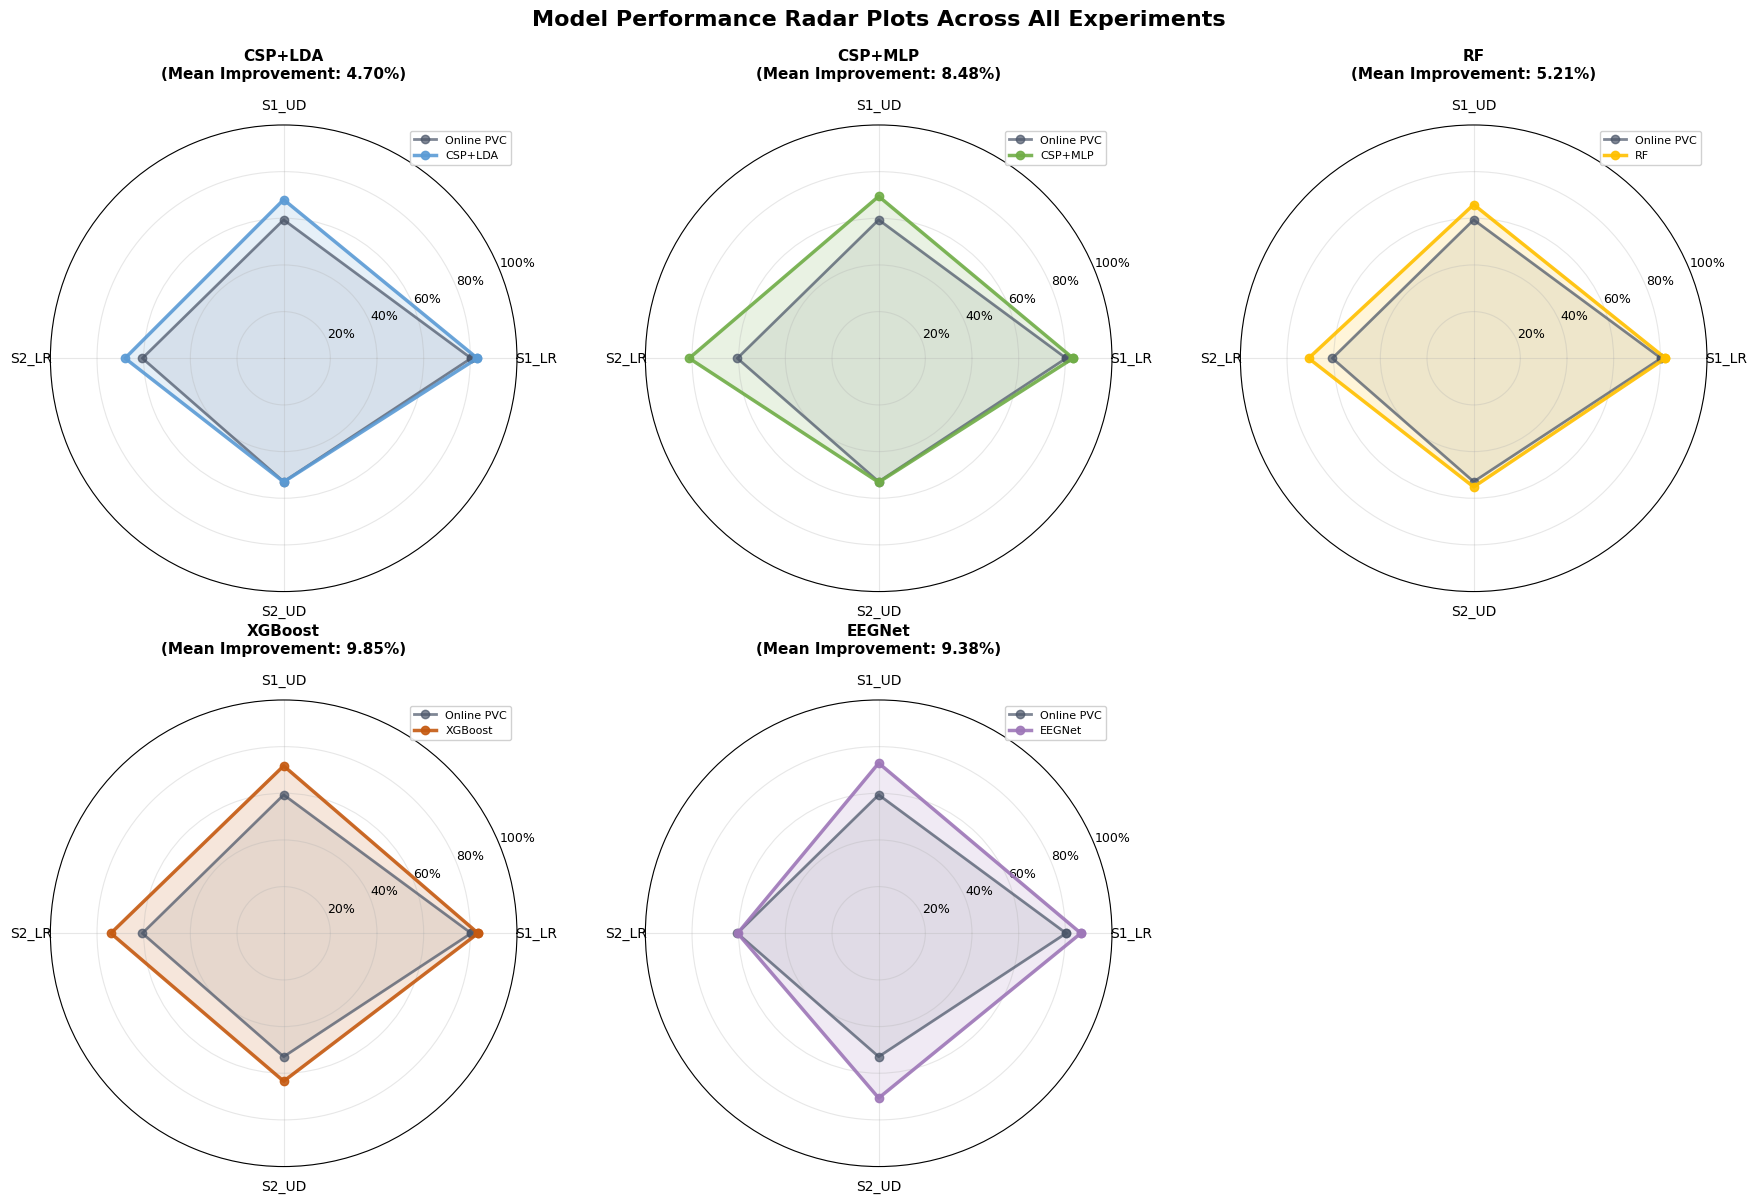

Saved combined radar plot to report_figures/combined_radar_plot.png


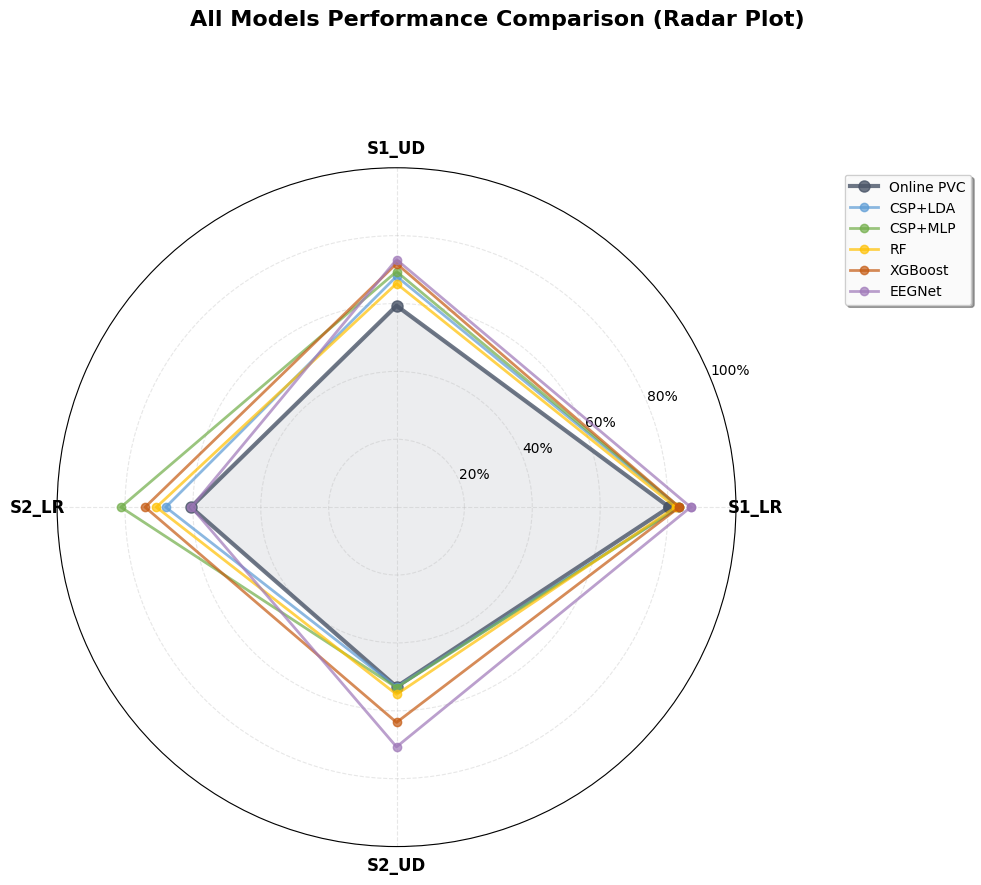

In [35]:
# ============================================================
# MODEL RANKING BY MEAN IMPROVEMENT OVER PVC
# ============================================================

print("\n" + "="*100)
print("MODEL RANKING BY MEAN IMPROVEMENT OVER PVC")
print("="*100)

# Calculate improvement over PVC for each model across all experiments
models_to_rank = ['CSP_LDA', 'CSP_MLP', 'RF', 'XGBoost', 'EEGNet']
model_labels_rank = ['CSP+LDA', 'CSP+MLP', 'RF', 'XGBoost', 'EEGNet']

improvements = {}
for model, label in zip(models_to_rank, model_labels_rank):
    # Calculate improvement = model_mean - PVC for each experiment
    model_means = comprehensive_results[f'{model}_Mean'].values
    pvc_values = comprehensive_results['PVC'].values
    improvement = model_means - pvc_values
    mean_improvement = np.mean(improvement) * 100  # Convert to percentage points
    improvements[label] = {
        'mean_improvement': mean_improvement,
        'improvements': improvement * 100,  # Store per-experiment improvements
        'std_improvement': np.std(improvement) * 100
    }

# Create ranking DataFrame
ranking_data = []
for model_label, data in improvements.items():
    ranking_data.append({
        'Model': model_label,
        'Mean Improvement (%)': data['mean_improvement'],
        'Std Improvement (%)': data['std_improvement']
    })

ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Mean Improvement (%)', ascending=False)
ranking_df['Rank'] = range(1, len(ranking_df) + 1)
ranking_df = ranking_df[['Rank', 'Model', 'Mean Improvement (%)', 'Std Improvement (%)']]
ranking_df = ranking_df.round(3)

print("\nModel Rankings (sorted by mean improvement over PVC):")
print(ranking_df.to_string(index=False))
print("\n" + "="*100)

# ============================================================
# RADAR PLOTS: Model Performance Across All Experiments
# ============================================================

from math import pi

# Prepare data for radar plots
experiments = ['S1_LR', 'S1_UD', 'S2_LR', 'S2_UD']
angles = [n / float(len(experiments)) * 2 * pi for n in range(len(experiments))]
angles += angles[:1]  # Complete the circle

# Create figure with subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
fig.suptitle('Model Performance Radar Plots Across All Experiments', 
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Colors matching the bar plot
colors_dict = {
    'Online PVC': '#4A5568',
    'CSP+LDA': '#5B9BD5',
    'CSP+MLP': '#70AD47',
    'RF': '#FFC000',
    'XGBoost': '#C55A11',
    'EEGNet': '#9E77B8'
}

# Plot each model
plot_idx = 0
for model, label in zip(models_to_rank, model_labels_rank):
    ax = axes_flat[plot_idx]
    
    # Get model values (in percentage)
    model_values = comprehensive_results[f'{model}_Mean'].values * 100
    model_values = np.append(model_values, model_values[0])  # Complete the circle
    
    # Get PVC values for comparison
    pvc_plot = comprehensive_results['PVC'].values * 100
    pvc_plot = np.append(pvc_plot, pvc_plot[0])  # Complete the circle
    
    # Plot PVC baseline
    ax.plot(angles, pvc_plot, 'o-', linewidth=2, label='Online PVC', 
            color=colors_dict['Online PVC'], alpha=0.7)
    ax.fill(angles, pvc_plot, alpha=0.1, color=colors_dict['Online PVC'])
    
    # Plot model performance
    ax.plot(angles, model_values, 'o-', linewidth=2.5, label=label,
            color=colors_dict[label], alpha=0.9)
    ax.fill(angles, model_values, alpha=0.15, color=colors_dict[label])
    
    # Customize
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(experiments, fontsize=10)
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{label}\n(Mean Improvement: {improvements[label]["mean_improvement"]:.2f}%)', 
                 fontsize=11, fontweight='bold', pad=15)
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    
    plot_idx += 1

# Hide the last subplot (we only have 5 models)
axes_flat[5].axis('off')

plt.tight_layout()

# Save figure
os.makedirs("report_figures", exist_ok=True)
plt.savefig("report_figures/model_radar_plots.png", dpi=300, bbox_inches='tight')
print("\nSaved radar plots to report_figures/model_radar_plots.png")

plt.show()

# ============================================================
# COMBINED RADAR PLOT: All Models Together
# ============================================================

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('All Models Performance Comparison (Radar Plot)', 
             fontsize=16, fontweight='bold', y=0.98)

# Plot PVC baseline
pvc_combined = comprehensive_results['PVC'].values * 100
pvc_combined = np.append(pvc_combined, pvc_combined[0])
ax.plot(angles, pvc_combined, 'o-', linewidth=3, label='Online PVC', 
        color=colors_dict['Online PVC'], alpha=0.8, markersize=8)
ax.fill(angles, pvc_combined, alpha=0.1, color=colors_dict['Online PVC'])

# Plot all models
for model, label in zip(models_to_rank, model_labels_rank):
    model_vals = comprehensive_results[f'{model}_Mean'].values * 100
    model_vals = np.append(model_vals, model_vals[0])
    ax.plot(angles, model_vals, 'o-', linewidth=2, label=label,
            color=colors_dict[label], alpha=0.7, markersize=6)

# Customize
ax.set_xticks(angles[:-1])
ax.set_xticklabels(experiments, fontsize=12, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), fontsize=10, 
          framealpha=0.95, fancybox=True, shadow=True)

plt.tight_layout()

# Save figure
plt.savefig("report_figures/combined_radar_plot.png", dpi=300, bbox_inches='tight')
print("Saved combined radar plot to report_figures/combined_radar_plot.png")

plt.show()

print("\n" + "="*100)


<!-- # PREPROESSING STEP -->